### Лабораторная работа "Обработка данных о вакансиях"
### по курсу "Модели и методы обработки больших объемов информации"
### выполнил Зязюлькин С.П., студент группы 956241

#### Постановка задачи

1. Найти источник данных о вакансиях в Беларуси.
1. Реализовать выгрузку данных о вакансиях.
1. Выполнить обработку загруженных данных.
1. Провести анализ обработанных данных, сделать выводы.

#### Импорт используемых модулей

In [1]:
import scrapy
from scrapy.crawler import CrawlerProcess
import re
import os
import logging
import io
import json
import matplotlib.pyplot as plt
from collections import Counter
import datetime as dt

#### Получение данных

В качестве источника данных выбран сайт https://rdw.by/vakansii. На этом сайте размещаются вакансии. На момент выгрузки сайт содержит 5390 вакансий. Для каждой вакансии выгружаются следующие данные: дата подачи вакансии, должность, наниматель, предлагаемая заработная плата (может быть указана в формате "от", "до", "от до" или не указана вовсе), требуемый уровень образования, требуемый опыт (может быть указан в формате "от", "менее" или "не важен"), город и категория вакансии.

Выгрузка данных реализуется на языке программирования Python с использованием фреймворка Scrapy.
Для извлечения данных из html-страниц использовались css selectors и XPath.

In [2]:
class JobsSpider(scrapy.Spider):
    name = 'jobs_spider'
    start_urls = ['https://rdw.by/vakansii']
    
    @staticmethod
    def _extract(string):
        if string is not None:
            search_res = re.search('\s{2,}([\S ]+)', string)
            if search_res:
                return search_res.group(1).strip()
            else:
                print(f'Extracting failed: {string}')
                return string
        else:
            return None
    
    @staticmethod
    def _to_json(job):
        return {
            'date': job.css('.date::text').extract_first(),
            'name': job.css('.url_title::text').extract_first(),
            'employer': job.css('p::text').extract_first(),
            'salary': JobsSpider._extract(job.css('.icon_1 strong::text').extract_first()),
            'education': JobsSpider._extract(job.css('.icon_5::text').extract_first()),
            'experience': JobsSpider._extract(job.css('.icon_6::text').extract_first()),
            'place': job.css('.icon_3::text').extract_first(),
            'category': job.css('.icon_4::text').extract_first(),
        }
    
    def parse(self, response):
        for job in response.css('.highlighted'):
            yield JobsSpider._to_json(job)
        
        for job in response.css('li[class=""]'):
            yield JobsSpider._to_json(job)
            
        next_page = response.css('.url_next::attr(href)').extract_first()
        if next_page:
            yield scrapy.Request(
            response.urljoin(next_page),
            callback=self.parse
        )

In [3]:
jobs_file = 'jobs.json'

In [ ]:
if os.path.isfile(jobs_file):
    os.remove(jobs_file)

process = CrawlerProcess({
    'LOG_LEVEL': logging.WARNING,
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)',
    'FEED_FORMAT': 'json',
    'FEED_URI': jobs_file,
    'FEED_EXPORT_ENCODING': 'utf-8',
})

process.crawl(JobsSpider)
process.start()

#### Хранение и предобработка данных

Полученные данные сохранены в формате json: хранится список json-объектов, каждый из которых представляет собой данные одной вакансии. 

Пример json-объекта:
`{"date": "30.11.2019 | 09:27", "name": "Водитель кат. С", "employer": "Государственное предприятие «Октябрьский ГК»", "salary": null, "education": "любое", "experience": "от 1 года", "place": "Минск", "category": "Общепит, рестораны, гостиницы, игорный бизнес"}`

При загрузке данных перед анализом выполняется их предобработка в классе Job:
1. Из поля "данные размещения вакансии" при помощи регулярного выражения извлекается дата.
1. Если отсутствует имя вакансии, то оно заменяется на "Не указано". Также удаляются специальные символы из имени вакансии.
1. Из поля "заработная плата" (пример формата: от 1 000 Br, от 100 до  10 000 Br) извлекается верхняя и нижняя граница заработной платы при помощи регулярного выражения. Одна или обе границы могут быть не указаны.
1. Аналогично предыдущему пункту обрабатывается поле "опыт работы".
1. Если не указана категория вакансии, то она заменяется на "Не указана".
1. Для всех полей, содержащих категориальные данные, формируется множество допустимых значений.

In [4]:
class Job:
    names = set()
    employers = set()
    education_types = set()
    places = set()
    categories = set()
    
    def __init__(self, json):
        self.date = Job._parse_date(json['date'])
        self.name = Job._parse_name(json['name'])
        self.employer = Job._parse_employer(json['employer'])
        self.min_salary, self.max_salary = Job._parse_salary(json['salary'])
        self.education = Job._parse_education(json['education'])
        self.min_experience = Job._parse_experience(json['experience'])
        self.place = Job._parse_place(json['place'])
        self.category = Job._parse_category(json['category'])
        self._update_discrete_data()
        
    @staticmethod
    def _parse_date(date):
        assert date is not None
        search_res = re.search(f'[0-9]+\.[0-9]+\.[0-9]+', date)
        assert search_res
        return search_res.group(0)
    
    @staticmethod
    def _parse_name(name):
        return 'Не указано' if name is None else name.replace('\u200e', '').replace('\u2062', '')
    
    @staticmethod
    def _parse_employer(employer):
        assert employer is not None
        return employer
    
    @staticmethod
    def _search_int_data(keyword, string):
        search_res = re.search(f'{keyword} +([0-9 ]+)', string)
        return int(search_res.group(1).replace(' ', '')) if search_res else None
        
    @staticmethod
    def _parse_salary(salary):
        if salary is not None:
            assert salary.endswith('Br')
            min_salary = Job._search_int_data('от', salary)
            max_salary = Job._search_int_data('до', salary)
            assert min_salary is not None or max_salary is not None
            return min_salary, max_salary
        else:
            return None, None
    
    @staticmethod
    def _parse_education(education):
        assert education is not None
        return education
    
    @staticmethod
    def _parse_experience(experience):
        if experience is not None:
            min_experience = Job._search_int_data('от', experience)
            max_experience = Job._search_int_data('менее', experience)
            
            if min_experience is not None or max_experience is not None:
                assert max_experience is None or max_experience == 1
                return min_experience if min_experience is not None else 0
            else:
                assert experience == 'без опыта' or experience == 'не важно'
                return 0
        else:
            return None
    
    @staticmethod
    def _parse_place(place):
        assert place is not None
        return place
    
    @staticmethod
    def _parse_category(category):
        return 'Не указана' if category is None else category
    
    def _update_discrete_data(self):
        Job.names.add(self.name)
        Job.employers.add(self.employer)
        Job.education_types.add(self.education)
        Job.places.add(self.place)
        Job.categories.add(self.category)
    
    def __str__(self):
        return str({
            'date': self.date,
            'name': self.name,
            'employer': self.employer,
            'min_salary': self.min_salary,
            'max_salary': self.max_salary,
            'education': self.education,
            'min_experience': self.min_experience,
            'place': self.place,
            'category': self.category
        })

In [5]:
with io.open(jobs_file, encoding='utf-8') as json_file:
    jobs_json = json.load(json_file)

jobs = [Job(job_json) for job_json in jobs_json]

#### Значения категориальных полей. 

Для наймодателей и наименований вакансий указана лишь часть значений.

In [6]:
def print_data(msg, data):
    print(f'{msg}:')
    print(len(data))
    print(data)

In [7]:
print_data('Education types', Job.education_types)

Education types:
7
{'среднее', 'профессионально-техническое', 'любое', 'среднее специальное', 'без образования', 'высшее', 'неоконченное высшее'}


In [8]:
print_data('Places', Job.places)

Places:
65
{'Глубокое', 'Крупки', 'Миоры', 'Гомель', 'Пуховичи', 'Червень', 'Волковыск', 'Бобруйск', 'Раков', 'Кобрин', 'Лоев', 'Орша', 'Березино', 'Слоним', 'Могилев', 'Жлобин', 'Давид-Городок', 'Фаниполь', 'Сморгонь', 'Солигорск', 'Поставы', 'Старые Дороги', 'Петриков', 'Гродно', 'Узда', 'Ивацевичи', 'Мозырь', 'Речица', 'Полоцк', 'Жабинка', 'Светлогорск', 'Борисов', 'Кричев', 'Логойск', 'Молодечно', 'Минск', 'Шклов', 'Лида', 'Мачулищи', 'Барановичи', 'Боровляны', 'Столбцы', 'Береза', 'Жодино', 'Несвиж', 'Слуцк', 'Новополоцк', 'Брест', 'Ляховичи', 'Заславль', 'Марьина Горка', 'Любань', 'Дзержинск', 'Калинковичи', 'Рогачёв', 'Клецк', 'Быхов', 'Лунинец', 'Воложин', 'Осиповичи', 'Витебск', 'Пинск', 'Смолевичи', 'Островец', 'Докшицы'}


In [9]:
print_data('Employers', list(Job.employers)[:100])

Employers:
100
['УП «Скульптурный комбинат»', 'ООО «ИнтерТехСтрой»', 'ИП «Осмоловский С. Б.»', 'ООО «Стандартикс»', 'ОДО «Экология города»', 'ИП «Данильчик А. М.»', 'ООО «Прайв»', 'ООО «НекстТрэйд»', 'ООО «Аккорд Маркет»', 'ИП «Гриневич Н.П.»', 'ООО «Фабрика Ромакс»', 'ООО «Буд М»', 'ОАО «Станкозавод "Красный борец"»', 'ОДО «ГидроТехСервис»', 'ИП «Водотыка Сергей Владимирович»', 'ООО «ГлобалИнжСтрой»', 'ООО «НУКУСТРЕЙД»', 'ГУ «Государственный комитет по стандартизации Республики Беларусь»', 'Филиал «РУП «Белсудэкспертобеспечение»»', ' «Бамбуковый рай»', ' «Беласептика»', 'ЧТУП «Ивафарм»', 'ООО «ГомельФарм»', 'ООО «Ратардинус»', 'ИП «Ковзан Александр Леонидович»', 'ПЧУП «Центр проблем детского развития «Левания»»', 'ООО «Лар-М»', 'ЧУП «Виали»', 'УП «Санта-Сервис»', 'ООО «Стройторгсервис»', 'ОАО «Смолевичский райагросервис»', 'ЗАО «Мебель, стройматериалы»', 'ООО «Вертикальный транспорт»', 'УП «Цветмет»', 'ООО «ПС Кромка»', 'УП «Спиридон»', 'ЧП «Басок А.В.»', 'ООО «Ложкин»', 'ЧУП «Вуджи»'

In [10]:
print_data('Job categories', Job.categories)

Job categories:
22
{'Транспорт, автобизнес, автосервис', 'Сельское хозяйство, агробизнес', 'Бытовые услуги, ЖКХ, услуги для населения', 'Образование, наука, культура', 'Не указана', 'Красота, спорт, фитнес', 'Бухгалтерия, финансы, банки', 'СМИ, издательства, реклама, маркетинг', 'IT, Интернет, телекоммуникации, связь', 'Туризм, агротуризм', 'Недвижимость', 'Оптовая торговля', 'Общепит, рестораны, гостиницы, игорный бизнес', 'Склад, логистика, ВЭД', 'Розничная торговля', 'Строительство, эксплуатация, ремонт, проектирование', 'Кадровые, консалтинговые агентства, бизнес-образование', 'Промышленное производство', 'Производство продуктов питания', 'Медицина, фармацевтика, аптеки', 'Производство товаров народного потребления', 'Охрана, милиция, безопасность'}


In [11]:
print_data('Job names', list(Job.names)[:110])

Job names:
110
['Водитель такси Uber/Яндекс на автомобиле компании', 'Мастер/прораб', 'Литейщик металлов и сплавов', 'Начальник теплоэлектроцентрали', 'Огнеупорщик (каменщик)', 'Продавец (ул. Красноармейская)', 'Сварщик-универсал', 'Повар, повар-шаурмист', 'Токарь 4 р.', 'Администратор-инструктор лазертаг-клуба', 'Менеджер по продажам ведущий', 'Мастер по техническому обслуживанию защитных сооружений', 'Оператор-консультант', 'Главный бухгалтер', 'Помощник бухгалтера / Офис-менеджер', 'Менеджер по продажам автошин', 'Агент коммерческий по г. Бресту (мерчендайзер)', 'Швея вахтой (спецодежда)', 'Инженер по материально-техническому снабжению', 'Энергетик', 'Врач-стоматолог', 'Наладчик КИПиА', 'Рамщик ленточнопильной пилорамы', 'Штамповщик', 'Провизор / Фармацевт', 'Прораб (мастер)', 'Педагог-психолог', 'Водитель погрузчика 6 разряда', 'Зачистник (дробеструйщик)', 'Старший контролер-кассир (г.Гомель, ул.Барыкина,84)', 'Специалист по качеству товаров (изучение состояния работы торговых объе

#### Аналитика и построение графиков

При анализе данных использовался собственный код на основе функционала стандартной библиотеки Python. Для построения графиков использовалась библиотека matplotlib.

In [14]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., height * 1.05, '%d' % int(height), ha='center', va='bottom')

In [15]:
def plot_count(jobs, extractor, xlabel, title=None, top_n=None, other=True):
    counter = Counter([extractor(job) for job in jobs])
    data = sorted(counter.items(), key=lambda item: item[1], reverse=True)
    if top_n is not None:
        assert top_n < len(data)
        other_count = sum([el[1] for el in data[top_n:]])
        data = data[:top_n]
        if other:
            data.append(('Остальные', other_count))
    
    print(data)
    plt.figure(figsize=(8, 5))
    if title:
        plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Число вакансий')
    plt.xticks(rotation='vertical')
    rects = plt.bar([el[0] for el in data], [el[1] for el in data])
    autolabel(rects)

[('любое', 2998), ('профессионально-техническое', 1153), ('высшее', 498), ('среднее', 373), ('среднее специальное', 360), ('без образования', 6), ('неоконченное высшее', 2)]


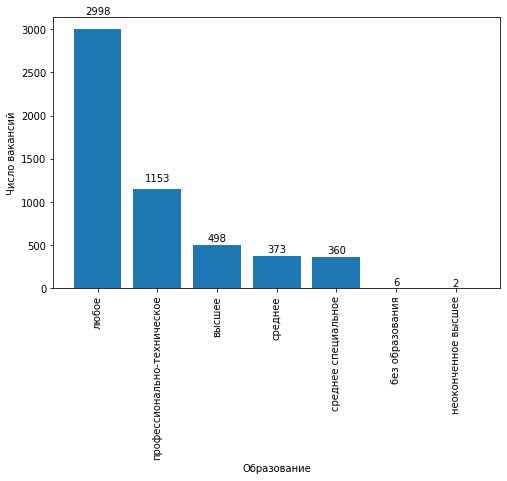

In [16]:
plot_count(jobs, lambda job: job.education, 'Образование')

Больше половины вакансий не требует наличия образования. Сравнительно большое число вакансий требует профессионально-техническое образование. Высшее образование требуется всего лишь менее 500 вакансиями.

[('Минск', 3046), ('Брест', 459), ('Могилев', 429), ('Витебск', 388), ('Гродно', 305), ('Гомель', 278), ('Молодечно', 45), ('Барановичи', 42), ('Смолевичи', 35), ('Борисов', 33), ('Пинск', 25), ('Заславль', 20), ('Остальные', 285)]


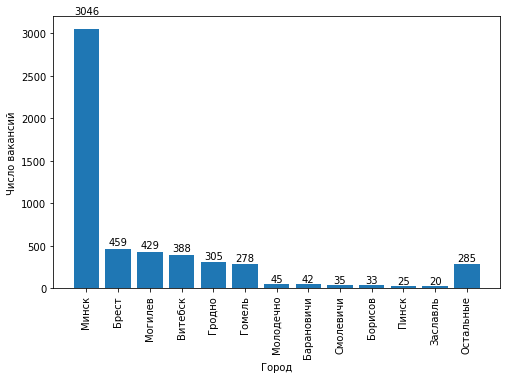

In [17]:
plot_count(jobs, lambda job: job.place, 'Город', top_n=12)

Как и ожидалось, больше половины вакансий предлагается в Минске. Остальные областные центры идут за Минском и предлагают сравнимое (между собой) число вакансий. Остальные города в отдельности предлагают заметно меньшее число вакансий, чем областные центры.

[('Не указана', 2317), ('Строительство, эксплуатация, ремонт, проектирование', 720), ('Промышленное производство', 484), ('Транспорт, автобизнес, автосервис', 433), ('Розничная торговля', 333), ('Общепит, рестораны, гостиницы, игорный бизнес', 204), ('Производство продуктов питания', 193), ('Производство товаров народного потребления', 122), ('Бытовые услуги, ЖКХ, услуги для населения', 101), ('Кадровые, консалтинговые агентства, бизнес-образование', 87), ('Образование, наука, культура', 80), ('Красота, спорт, фитнес', 74), ('Оптовая торговля', 60), ('Медицина, фармацевтика, аптеки', 49), ('Сельское хозяйство, агробизнес', 28), ('СМИ, издательства, реклама, маркетинг', 28), ('Склад, логистика, ВЭД', 24), ('IT, Интернет, телекоммуникации, связь', 18), ('Туризм, агротуризм', 13), ('Недвижимость', 8), ('Охрана, милиция, безопасность', 7), ('Бухгалтерия, финансы, банки', 7)]


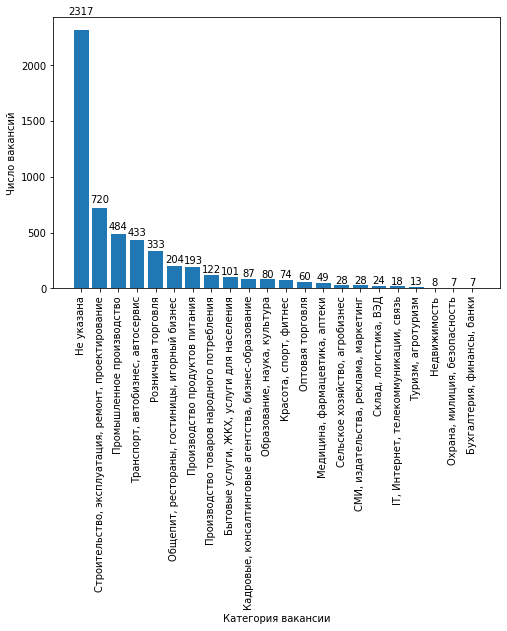

In [18]:
plot_count(jobs, lambda job: job.category, 'Категория вакансии')

Для почти половины вакансий не указана их категория. С существенным отрывом лидирует категория "Строительство, эксплуатация, ремонт, проектирование". 

[('Повар', 113), ('Каменщик', 83), ('Водитель', 79), ('Продавец', 79), ('Водитель-международник', 73), ('Швея', 68), ('Электрогазосварщик', 64), ('Грузчик', 58), ('Кухонный рабочий', 53), ('Электромонтер по ремонту и обслуживанию электрооборудования', 51), ('Продавец-консультант', 51), ('Штукатур', 46)]


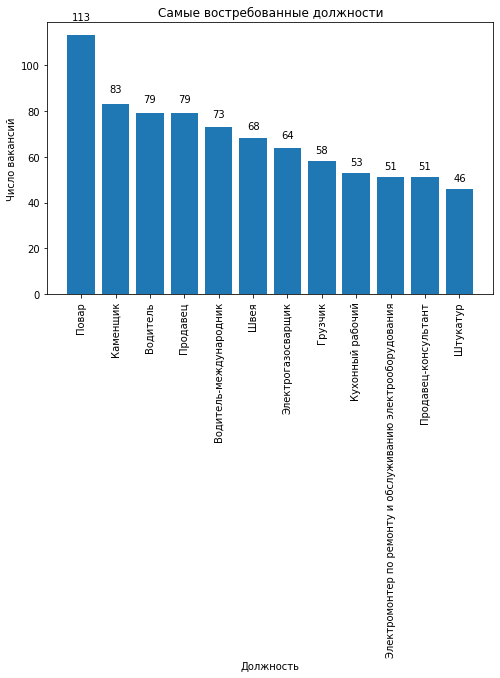

In [19]:
plot_count(jobs, lambda job: job.name, 'Должность', title='Самые востребованные должности', top_n=12, other=False)

Если объединить на графике схожие должности "Повар" и "Кухонный рабочий", "Водитель" и "Водитель-международник", "Продавец" и "Продавец-консультант", то в сумме они будут самыми востребованными. Выходит, проще всего найти работу продавцам, водителям и поварам.

[('ООО «Тапас плюс»', 108), ('ОАО «Минский подшипниковый завод»', 100), ('ОДО «СБФ-Плюс»', 66), ('ООО «Эстон Индастри»', 66), ('ОАО «СУ-94 Стройтрест №1»', 60), ('ОАО «Смолевичи Бройлер»', 49), ('ОАО «Моготекс»', 45), ('ОАО «Автосила»', 42), ('ОАО «СУ-26 Стройтрест №4»', 42), ('РУП «Автобусный парк №4»', 40), ('ОАО «Молоко»', 40), ('ИП «Волотовская В.С.»', 40)]


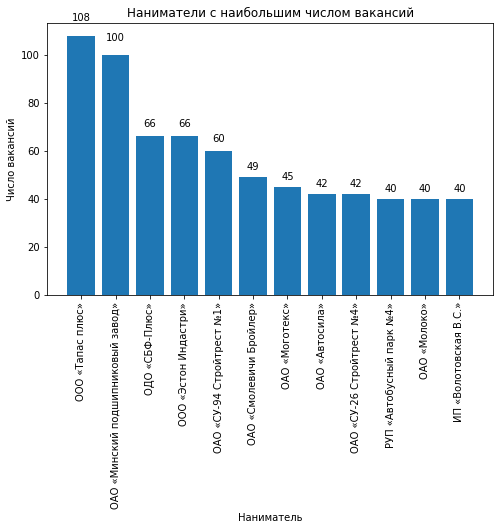

In [20]:
plot_count(jobs, lambda job: job.employer, 'Наниматель', title='Наниматели с наибольшим числом вакансий', top_n=12, other=False)

В топе нанимателей фигурируют застройщики. Например, ООО "Тапас плюс" и ОДО "СБФ-Плюс".

[('30.11.2019', 594), ('29.11.2019', 437), ('28.11.2019', 699), ('27.11.2019', 86), ('26.11.2019', 71), ('25.11.2019', 322), ('23.11.2019', 1), ('22.11.2019', 68), ('21.11.2019', 51), ('20.11.2019', 43), ('19.11.2019', 103), ('18.11.2019', 104), ('16.11.2019', 74), ('15.11.2019', 139), ('14.11.2019', 77), ('13.11.2019', 50), ('12.11.2019', 93), ('11.11.2019', 55), ('09.11.2019', 1), ('08.11.2019', 3), ('07.11.2019', 77), ('06.11.2019', 124), ('05.11.2019', 79), ('04.11.2019', 174), ('01.11.2019', 52), ('31.10.2019', 126), ('30.10.2019', 51), ('29.10.2019', 47), ('28.10.2019', 45), ('25.10.2019', 38), ('24.10.2019', 62), ('23.10.2019', 54), ('22.10.2019', 31), ('21.10.2019', 50), ('18.10.2019', 36), ('17.10.2019', 31), ('16.10.2019', 56), ('15.10.2019', 43), ('14.10.2019', 14), ('12.10.2019', 19), ('11.10.2019', 52), ('10.10.2019', 52), ('09.10.2019', 23), ('08.10.2019', 47), ('07.10.2019', 34), ('04.10.2019', 35), ('03.10.2019', 37), ('02.10.2019', 25), ('01.10.2019', 15), ('30.9.2019'

<BarContainer object of 98 artists>

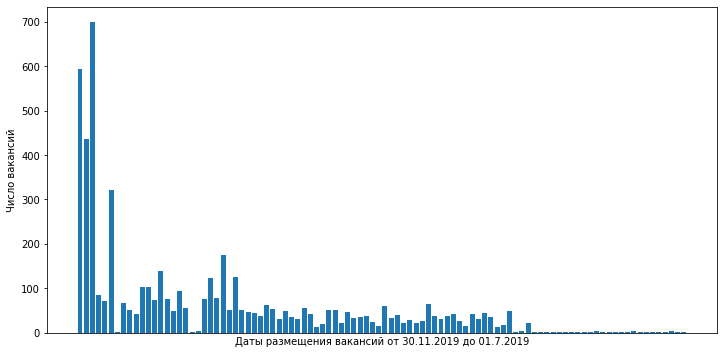

In [22]:
counter = Counter([job.date for job in jobs])
data = sorted(counter.items(), key=lambda item: dt.datetime.strptime(item[0], '%d.%m.%Y'), reverse=True)
print(data)
plt.figure(figsize=(12, 6))
plt.xlabel(f'Даты размещения вакансий от {data[0][0]} до {data[-1][0]}')
plt.ylabel('Число вакансий')
plt.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
plt.bar(range(len(data)), [el[1] for el in data])

Какой-то особой структуры в дате размещения вакансий не выявлено, не считая того, что более "свежих" вакансий больше. Также было выявлено, что вакансии не размещаются по воскресеньям.

В анализе заработной платы участвуют только те категории, для которых указана одновременно и верхняя, и нижняя граница заработной платы. Категории, для которых не указана хотя бы одна из границ, отбрасываются.

In [25]:
def median_of(vals):
    vals_sorted = sorted(vals)
    if len(vals_sorted) % 2 == 0:
        return (vals_sorted[len(vals_sorted) // 2] + vals_sorted[(len(vals_sorted) // 2) - 1]) / 2
    else:
        return vals_sorted[len(vals_sorted) // 2]

In [31]:
def plot_salary(jobs, extractor, xlabel, title=None, top_n=None, med=False):
    min_salaries, max_salaries = {}, {}
    for job in jobs:
        label = extractor(job)
        if job.min_salary is not None:
            if label in min_salaries:
                min_salaries[label].append(job.min_salary)
            else:
                min_salaries[label] = [job.min_salary]
        if job.max_salary is not None:
            if label in max_salaries:
                max_salaries[label].append(job.max_salary)
            else:
                max_salaries[label] = [job.max_salary]
    min_salaries_min, min_salaries_med = {}, {}
    max_salaries_max, max_salaries_med = {}, {}
    for label, label_salaries in min_salaries.items():
        min_salaries_min[label] = min(label_salaries)
        min_salaries_med[label] = median_of(label_salaries)
    for label, label_salaries in max_salaries.items():
        max_salaries_max[label] = max(label_salaries)
        max_salaries_med[label] = median_of(label_salaries)
    data = sorted([(label, min_salary_med, max_salaries_med[label], min_salaries_min[label], max_salaries_max[label]) 
                   for label, min_salary_med in min_salaries_med.items()
                   if label in min_salaries_min and label in max_salaries_max and label in max_salaries_med], 
                   key=lambda e: e[2] if med else e[4],
                   reverse=True)
    if top_n is not None:
        assert top_n < len(data)
        data = data[:top_n]
   
    print(data)
    plt.figure(figsize=(8, 5))
    if title:
        plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Заработная плата')
    plt.xticks(rotation='vertical')
    plt.errorbar(
        [e[0] for e in data],
        [(e[3] + e[4]) / 2 for e in data],
        yerr=[(e[4] - e[3]) / 2 for e in data],
        ls='none',
        capsize=8,
        color='c',
        lw=1
    )
    plt.errorbar(
        [e[0] for e in data],
        [(e[1] + e[2]) / 2 for e in data],
        yerr=[(e[2] - e[1]) / 2 for e in data],
        ls='none',
        capsize=4,
        color='b',
        lw=2
    )

На графиках заработной платы будут отображены максимальные и медианные значения границ. Медианные значения границ не столь показательны, т.к. существует большой разброс в количестве данных в категориях. Так, категория с всего несколькими вакансиями, но вакансиями, имеющими высокие показатели заработной платы, будет несправедливо вырываться вперёд. Поэтому сортировка на графиках идёт по максимальной верхней границе заработной платы.

[('любое', 800, 1000.0, 10, 10000), ('высшее', 800.0, 1000, 7, 10000), ('среднее специальное', 700.0, 800, 100, 4000), ('среднее', 735.0, 800.0, 200, 3500), ('профессионально-техническое', 800, 900.0, 180, 3000), ('без образования', 1000, 1000, 700, 3000), ('неоконченное высшее', 625.0, 2000, 250, 2000)]


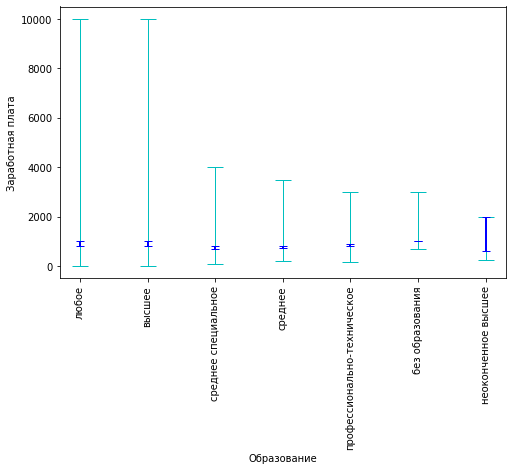

In [32]:
plot_salary(jobs, lambda job: job.education, 'Образование')

In [27]:
for job in jobs:
    if job.min_salary == 7 or job.max_salary == 10000:
        print(job)
        print()

{'date': '27.11.2019', 'name': 'Проектировщик систем вентиляции и кондиционирования Главный специалист', 'employer': 'ООО «Инжиниринг систем»', 'min_salary': 100, 'max_salary': 10000, 'education': 'высшее', 'min_experience': 0, 'place': 'Минск', 'category': 'Не указана'}

{'date': '11.11.2019', 'name': 'Водитель', 'employer': 'ОАО «КарТир»', 'min_salary': 1000, 'max_salary': 10000, 'education': 'любое', 'min_experience': 1, 'place': 'Гродно', 'category': 'Не указана'}

{'date': '06.11.2019', 'name': 'Преподаватель ландшафтного дизайна', 'employer': 'ПТЧУП «Стахис»', 'min_salary': 7, 'max_salary': None, 'education': 'высшее', 'min_experience': 1, 'place': 'Минск', 'category': 'Образование, наука, культура'}



Больше всего предлагается на вакансиях, требующих высшее образование, что ожидаемо, и на вакансиях, не требующих конкретного образования, что ожидается меньше. Примером вакансии, предлагающей до 10000 Br, но при этом не требующей образования, является "Водитель". Есть вакансии, которые предлагают всего от 7 Br. Примером такой вакансии является "Преподаватель ландшафтного дизайна". Возможно, в предлагаемой заработной плате опечатка, или плата указана не за месяц, а, например, за одно занятие. Полагаю, что последнее, т.к. ситуация аналогична для других вакансий преподавателей.

[('Минск', 800, 1000.0, 7, 10000), ('Гродно', 700, 800.0, 50, 10000), ('Заславль', 800, 1000, 450, 5000), ('Витебск', 700, 900, 10, 3800), ('Брест', 700, 800, 200, 3245), ('Гомель', 700, 1000.0, 200, 3000), ('Могилев', 700, 800, 10, 3000), ('Пинск', 550, 800, 200, 3000), ('Боровляны', 750.0, 2000.0, 600, 3000), ('Борисов', 700, 1200, 400, 2500), ('Мозырь', 500, 1000, 100, 2500), ('Барановичи', 700, 1200, 250, 2000)]


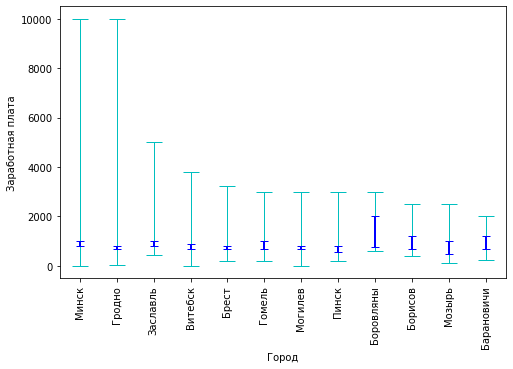

In [33]:
plot_salary(jobs, lambda job: job.place, 'Город', top_n=12)

In [29]:
for job in jobs:
    if job.place == 'Заславль' and job.max_salary and job.max_salary > 4000:
        print(job)
        print()

{'date': '04.11.2019', 'name': 'Вальщик леса', 'employer': 'ООО «Алтерос»', 'min_salary': 1000, 'max_salary': 5000, 'education': 'любое', 'min_experience': 3, 'place': 'Заславль', 'category': 'Промышленное производство'}



Как и ожидается, в топе городов фигурируют областные центры. Неожиданно туда попал Заславль с вакансией "Вальщик леса". Вакансии "Водитель" и "Проектировщик систем вентиляции и кондиционирования Главный специалист" позволяют Минску и Гродно занять первые строчки.

[('Не указана', 800, 1000, 10, 10000), ('Транспорт, автобизнес, автосервис', 1000, 1300.0, 100, 5000), ('Промышленное производство', 720.0, 900, 100, 5000), ('Туризм, агротуризм', 500.0, 1600, 200, 4800), ('Строительство, эксплуатация, ремонт, проектирование', 1000.0, 1500, 100, 4500), ('Оптовая торговля', 700, 1500, 350, 4500), ('Розничная торговля', 700, 850.0, 100, 3000), ('Склад, логистика, ВЭД', 725.0, 1350.0, 500, 2500), ('Недвижимость', 1100.0, 650, 600, 2500), ('IT, Интернет, телекоммуникации, связь', 800, 1600, 400, 2500), ('СМИ, издательства, реклама, маркетинг', 600, 1000, 200, 2400), ('Производство товаров народного потребления', 712.5, 800.0, 400, 2000), ('Бытовые услуги, ЖКХ, услуги для населения', 620.0, 750, 250, 2000), ('Образование, наука, культура', 400.0, 550, 7, 1800), ('Медицина, фармацевтика, аптеки', 800, 625.0, 420, 1500), ('Общепит, рестораны, гостиницы, игорный бизнес', 600.0, 700.0, 300, 1500), ('Сельское хозяйство, агробизнес', 750, 800, 400, 1500), ('Произ

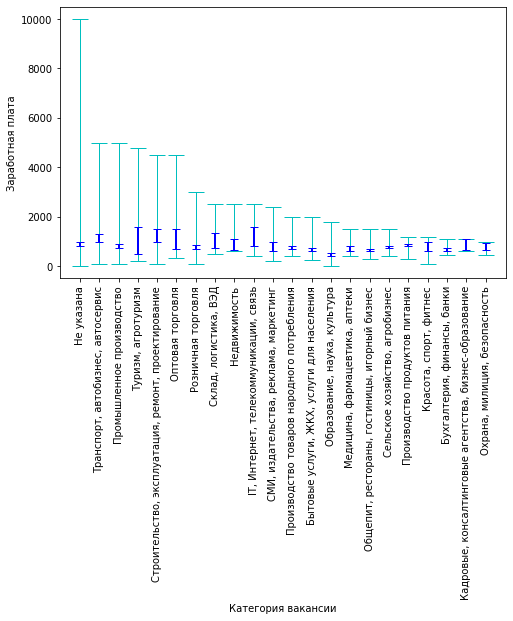

In [34]:
plot_salary(jobs, lambda job: job.category, 'Категория вакансии')

In [27]:
for job in jobs:
    if job.category == 'Бухгалтерия, финансы, банки':
        print(job)
        print()

{'date': '21.11.2019', 'name': 'Товаровед лобарда', 'employer': 'ЧУП «Залоговый Альянс»', 'min_salary': None, 'max_salary': 800, 'education': 'среднее специальное', 'min_experience': 0, 'place': 'Минск', 'category': 'Бухгалтерия, финансы, банки'}

{'date': '21.11.2019', 'name': 'Специалист по работе с клиентами', 'employer': 'ООО «Ломбард 1»', 'min_salary': 450, 'max_salary': 530, 'education': 'любое', 'min_experience': 0, 'place': 'Новополоцк', 'category': 'Бухгалтерия, финансы, банки'}

{'date': '19.11.2019', 'name': 'Бухгалтер 1С', 'employer': 'ЧУП «БухИнфоСервис»', 'min_salary': 600, 'max_salary': 800, 'education': 'высшее', 'min_experience': 3, 'place': 'Минск', 'category': 'Бухгалтерия, финансы, банки'}

{'date': '13.11.2019', 'name': 'Бухгалтер', 'employer': 'ИП «Данильчик А. М.»', 'min_salary': 700, 'max_salary': None, 'education': 'любое', 'min_experience': 1, 'place': 'Минск', 'category': 'Бухгалтерия, финансы, банки'}

{'date': '21.10.2019', 'name': 'Экономист-бухгалтер', 'e

Всё те же вакансии "Водитель" и "Проектировщик систем вентиляции и кондиционирования Главный специалист" ставят категорию "Не указана" на первое место. Заметно выше остальных располагаются категории "Транспорт, автобизнес, автосервис", "Промышленное производство", "Туризм, агротуризм", "Строительство, эксплуатация, ремонт, проектирование", "Оптовая торговля". В самом хвосте находятся "Производство продуктов питания", "Красота, спорт, фитнес", "Бухгалтерия, финансы, банки", "Кадровые, консалтинговые агенства, бизнес-образование", "Охрана, милиция, безопасность". Особенно удивительно видеть категорию "Бухгалтерия, финансы, банки" третьей с конца по максимальной предлагаемой заработной плате. От этой категории обычно ожидаются высокие доходы.

[('Водитель', 1000.0, 1350.0, 400, 10000), ('Проектировщик систем вентиляции и кондиционирования Главный специалист', 100, 10000, 100, 10000), ('Менеджер по продажам со знанием французского языка', 1420, 6500, 1420, 6500), ('Менеджер по продажам на международный рынок', 1420, 6500, 1420, 6500), ('Специалист по продажам', 800.0, 2500, 400, 5000), ('Вальщик леса', 1000.0, 5000, 1000, 5000), ('Менеджер по продаже недвижимости', 1500, 5000, 1500, 5000), ('Менеджер по продажам (туризму)', 800, 4800, 800, 4800), ('Менеджер по развитию', 2300, 4500, 2300, 4500), ('Специалист по логистике/экспедитор', 1100, 4000, 1100, 4000), ('Водитель такси', 1000, 1500, 100, 4000), ('Менеджер по продаже', 650, 4000, 650, 4000)]


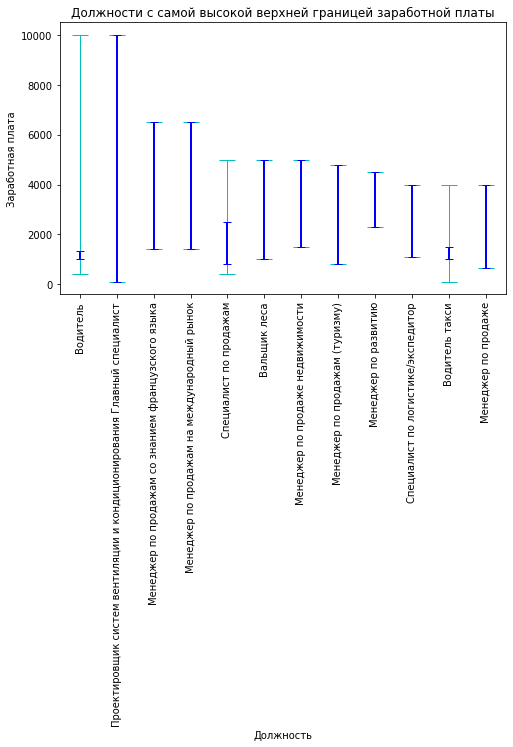

In [35]:
plot_salary(jobs, lambda job: job.name, 'Должность', title='Должности с самой высокой верхней границей заработной платы', top_n=12)

Интересно видеть, что должности с самой высокой возможной заработной платой также имеют очень низкую нижнюю границу. Заработная плата вакансии "Проектировщик систем вентиляции и кондиционирования Главный специалист" может варьироваться от 100 до 10000 Br, т.е. верхняя граница отличается от нижней в 100 раз. Похожая ситуация и у вакансии "Водитель". Вакансиями с высокой не только верхней, но и нижней границей заработной платы являются вакансии менеджеров, например "Менеджер по продажам со знанием французского языка". Стоит отметить, что среди должностей с самой высокой верхней границей заработной платы много менеджеров. Также заметим, что вакансии водителей имеют несравнимо меньшие медианные границы заработной платы.

[('ООО «Инжиниринг систем»', 100, 10000, 100, 10000), ('ОАО «КарТир»', 1000, 10000, 1000, 10000), ('ЧУП «Веб Маркетинг»', 1420.0, 6500.0, 1420, 6500), ('ООО «Алтерос»', 1000, 5000, 1000, 5000), ('ООО «Технотон Трейд»', 700, 5000, 700, 5000), ('ООО «Агентство недвижимости "Доки Реалти Плюс"»', 1500, 5000, 1500, 5000), ('ООО «Сильвер Пони»', 800, 4800, 800, 4800), ('ЧТУП «Изюм Хоум»', 2300, 4500, 2300, 4500), ('ООО «Иванса»', 740, 4500, 740, 4500), ('ООО «ВилтэксГрупп»', 1100, 4000, 1100, 4000), ('ЧТУП «Мустела»', 2000, 4000, 2000, 4000), ('ООО «Триол-продукт»', 650, 4000, 650, 4000)]


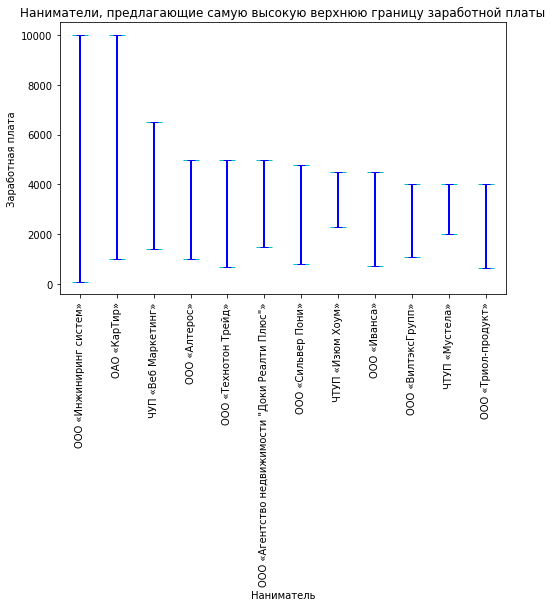

In [36]:
plot_salary(jobs, lambda job: job.employer, 'Наниматель', title='Наниматели, предлагающие самую высокую верхнюю границу заработной платы', top_n=12)

In [30]:
for job in jobs:
    if job.employer in ['ООО «Инжиниринг систем»', 'ОАО «КарТир»', 'ЧУП «Веб Маркетинг»']:
        print(job)
        print()

{'date': '27.11.2019', 'name': 'Проектировщик систем вентиляции и кондиционирования Главный специалист', 'employer': 'ООО «Инжиниринг систем»', 'min_salary': 100, 'max_salary': 10000, 'education': 'высшее', 'min_experience': 0, 'place': 'Минск', 'category': 'Не указана'}

{'date': '11.11.2019', 'name': 'Водитель', 'employer': 'ОАО «КарТир»', 'min_salary': 1000, 'max_salary': 10000, 'education': 'любое', 'min_experience': 1, 'place': 'Гродно', 'category': 'Не указана'}

{'date': '29.10.2019', 'name': 'Менеджер по продажам со знанием французского языка', 'employer': 'ЧУП «Веб Маркетинг»', 'min_salary': 1420, 'max_salary': 6500, 'education': 'любое', 'min_experience': 1, 'place': 'Минск', 'category': 'Не указана'}

{'date': '23.10.2019', 'name': 'Менеджер по продажам на международный рынок', 'employer': 'ЧУП «Веб Маркетинг»', 'min_salary': 1420, 'max_salary': 6500, 'education': 'любое', 'min_experience': 1, 'place': 'Минск', 'category': 'Не указана'}



ООО "Инжиниринг систем" ищет того самого "Проектировщик систем вентиляции и кондиционирования Главный специалист" с заработной платой до 10000 Br, а ОАО "КарТир" - того самого водителя. ЧУП "Веб Маркетинг" ищет менеджеров: "Менеджер по продажам со знанием французского языка", "Менеджер по продажам на международный рынок".

In [38]:
def plot_min_experience(jobs, extractor, xlabel, title=None, top_n=None):
    min_min_exps = {}
    for job in jobs:
        label = extractor(job)
        if label not in min_min_exps or job.min_experience < min_min_exps[label]:
            min_min_exps[label] = job.min_experience
    data = sorted([(label, min_min_exp) for label, min_min_exp in min_min_exps.items()],
                 key=lambda e: e[1],
                 reverse=True)
    if top_n is not None:
        assert top_n < len(data)
        data = data[:top_n]
    
    print(data)
    plt.figure(figsize=(8, 5))
    if title:
        plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Нижняя граница минимального требуемого опыта')
    plt.xticks(rotation='vertical')
    plt.bar([el[0] for el in data], [el[1] for el in data])

[('Производитель сантехнических работ (прораб)', 5), ('Инженер аттестованный', 5), ('Начальник лесопильного предприятия', 5), ('Швея-портной по ремонту одежды', 5), ('Сварщик-универсал', 5), ('Главный инженер проекта (ГИП)', 5), ('Начальник отдела эксплуатации сетей и систем звукоусиления / отображения информации / ЛВС / АСУ / ИО / ЦИТ', 5), ('Заведущий сектором', 5), ('Начальник центра информационных технологий', 5), ('Экономист по ценам', 5), ('Водитель-международник (категории CE)', 5), ('Рабочий по  комплексному обслуживанию зданий и  сооружений', 5), ('Ведущий специалист по закупкам и снабжению', 5), ('Начальник производственно-диспетчерского отдела', 5), ('Врач стоматолог-терапевт', 5), ('Парикмахер-стилист 5-го разряда', 5), ('ГИП, главный инженер проекта', 5), ('Инструктор по спорту', 5), ('Кладовщик-водитель', 5), ('Главный метролог', 5), ('Врач стоматолог-хирург', 5), ('Начальник отдела маркетинга', 5), ('Монтажник кухонь/шкафов купе (сборщик)', 5), ('Главный инженер проекта 

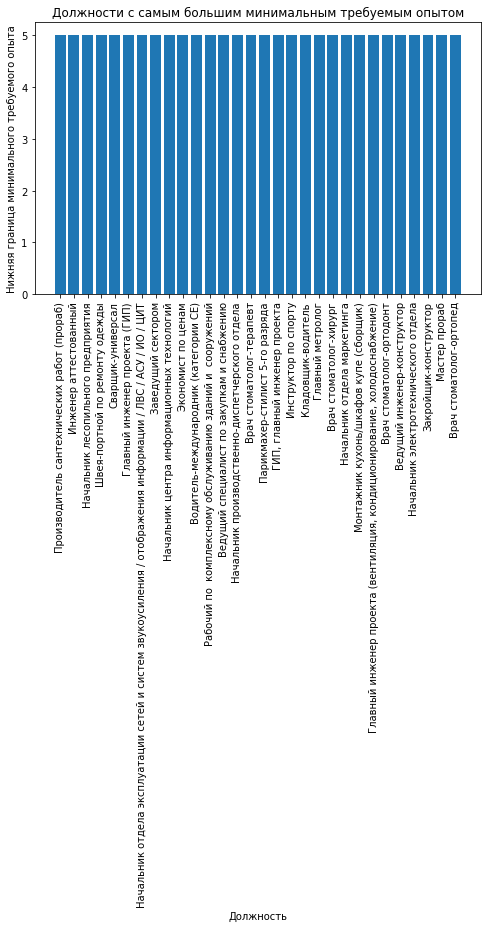

In [39]:
plot_min_experience(jobs, lambda job: job.name, 'Должность', title='Должности с самым большим минимальным требуемым опытом', top_n=30)

In [33]:
jobs_with_high_min_exp = [job for job in jobs if job.min_experience == 5 and job.min_salary]
print(median_of(map(lambda job: job.min_salary, jobs_with_high_min_exp)))

1000


Наибольший минимальный требуемый опыт составляет 5 лет. Среди вакансий, требующих такой опыт, много начальников, ведущих специалистов и, что интересно, врачей-стоматологов. Медианная минимальная заработная плата для вакансий, требующих такой опыт, составляет 1000 Br.

In [34]:
global_min_salary_min = min([job.min_salary for job in jobs if job.min_salary is not None])
global_max_salary_max = max([job.max_salary for job in jobs if job.max_salary is not None])
print(f'Salary absolute borders: {global_min_salary_min}-{global_max_salary_max}')

Salary absolute borders: 7-10000


In [35]:
global_min_salary_med = median_of([job.min_salary for job in jobs if job.min_salary is not None])
global_max_salary_med = median_of([job.max_salary for job in jobs if job.max_salary is not None])
print(f'Salary median borders: {global_min_salary_med}-{global_max_salary_med}')

Salary median borders: 800-1000.0


Медианная зарплата по Беларуси за май 2019-го года составила 802,7 рубля, что соответствует посчитанным медианным границам. Полагаю, людям значительно чаще платят ближе к минимальной границе предлагаемой заработной платы.

#### Краткий вывод

Результаты выполнения лабораторной работы:
1. Научился выполнять выгрузку данных с сайтов с использованием языка программирования Python, фреймворка Scrapy. Научился "вытягивать" данные из html-страницы при помощи css selectors, XPath.
1. Развил навыки работы с библиотекой matplotlib, используемой для построения графиков.
1. Развил навыки работы с языком программирования Python. В процессе выполнения лабораторной работы использовалось большое число модулей стандартной библиотеки: re (регулярные выражения), os (функционал ОС), logging (логирование), io (работа с файлами), json (обработка json), collections (структуры данных), datetime (работа с датой и временем).
1. Выполнил анализ данных о вакансиях и сделал выводы.

Все поставленные в пункте "Постановка задачи" задания полностью выполнены.